# Machine Learning Assignment: Regression Task

In [220]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'whitegrid', color_codes = True)

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split

#### จะพยายามแบ่งการทำ Model เป็น 3 model ใหญ่ๆคือ ARIMA, Regression และ Dynamic Regression

## Data Import

เลือกใช้ data จากภายนอกเพราะว่าต้องการค่าที่เป็นเวลาที่จริงขึ้น และสามารถนำข้อมูลอื่นๆ มาใช้ในการ Analysis และใช้ในการสร้าง model ชนิดอื่นด้วยโดย data ที่ได้เป็น data ที่ได้มาจากการ query ใน google bigquery โดยเลือกใช้ประเทศเป็น UK

In [36]:
df_res = pd.read_csv('UK_results-20200503-150942.csv') # from bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide
df_mob = pd.read_csv('UK_mobility_results-20200503-152437.csv') # from bigquery-public-data.covid19_google_mobility.mobility_report

In [37]:
df_mob.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

#### df_mob description 
This dataset aims to provide insights into what has changed in response to policies aimed at combating COVID-19. It reports movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

This dataset is intended to help remediate the impact of COVID-19. It shouldn’t be used for medical diagnostic, prognostic, or treatment purposes. It also isn’t intended to be used for guidance on personal travel plans. <br>
More at: https://www.google.com/covid19/mobility/data_documentation.html


# 1. ARIMA Model
เนื่องจาก ARIMA Model เป็น model ที่เป็น time series เลยจะใช้แค่ df_res ก่อนแล้วมาดู correlation ในตัว data อีกที

In [38]:
# Safety first
df_res2 = df_res.copy()

In [79]:
df_res = df_res2.copy()

In [80]:
# Set date column into index
df_res = df_res.set_index(['date'])
df_res.index = pd.to_datetime(df_res.index)

In [81]:
# slice dataframe because we use time series model so it only need 1 columns (of independent variables)
df_res = df_res.iloc[:, 3]
df_res.head(3)

date
2019-12-31    0
2020-01-01    0
2020-01-02    0
Name: daily_confirmed_cases, dtype: int64

Text(0, 0.5, 'Amount')

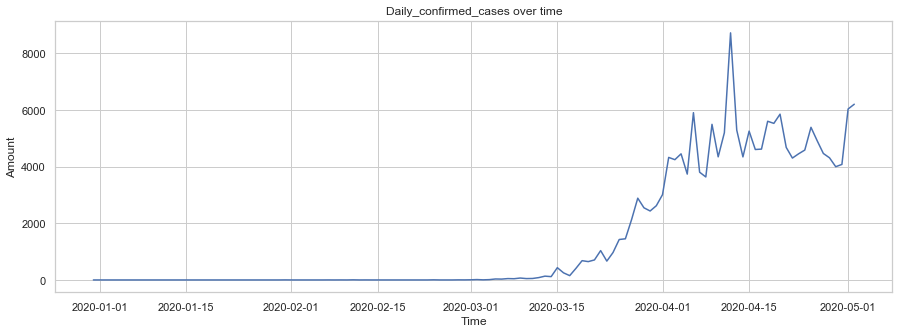

In [86]:
# Observed Daily confirmed Cases
plt.figure(figsize=(15, 5))
plt.plot(df_res)
plt.title('Daily_confirmed_cases over time')
plt.xlabel('Time')
plt.ylabel('Amount')

<hr>
<br>


# Might use for testing

<br>
<hr>

ดู Autocorrelation ใน daily change ในแต่ละวัน

In [158]:
daily_diff = df_res.diff()
daily_diff = daily_diff.dropna()
# Compute autocorrelation of daily different of confirmed cases
autocorr_daily = daily_diff.autocorr()
print("The autocorrelation of daily confirmed cases\
 is %4.2f" %(autocorr_daily))

The autocorrelation of daily confirmed cases is -0.30


ค่อนข้างส่งผลต่อค่าในวันถัดๆไป แต่ยังไงก็ต้องมาดู Autocorrelation function ว่า lags เก่าๆ(ค่าวันเก่า)มีผลทางตรงและทางอ้อมต่อวันต่อๆไปยังไงบ้าง

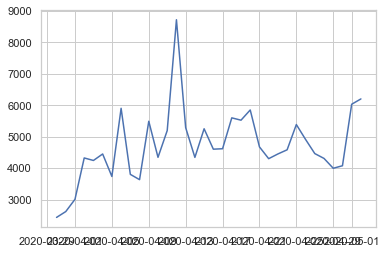

In [105]:
# plot to see if the confirmed cases is always up (check if it not cumulative)
plt.plot(df_res[90:])

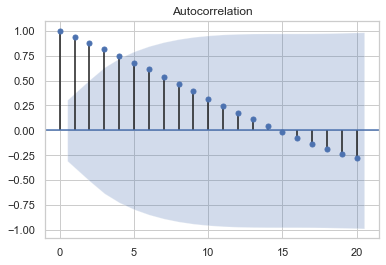

In [166]:
# define only 20 lags for plot and 95 % confidence interval
df_res_acf = acf(df_res)
plot_acf(df_res_acf, lags = 20, alpha = 0.05)
plt.show()

<hr>

เนื่องจากข้อมูลเป็น Non stationarity เพราะ mean และ variance ไม่เป็นค่าคงที่อาจจะทำให้การสร้าง ARIMA Model ทำนายออกมาได้ไม่ดี จึงลองใช้ differencing จากข้อมูลก่อนหน้านี้ และนำมาทำ AR Model ก่อน

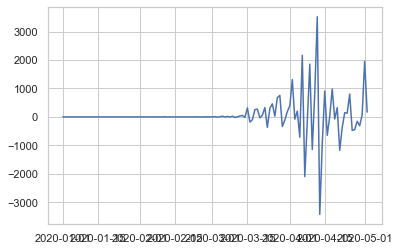

In [201]:
# Do AR Model and estimate order parameter
# First check if it still trend shape
daily_diff = df_res.diff(periods=1)
daily_diff = daily_diff.dropna()
plt.plot(daily_diff)

สังเกตุได้ว่ามีข้อมูลที่เป็น nan เยอะเพราะช่วงวันแรกๆ ไม่มีผู้ติดเชื้อ diff เลยเป็น 0 จึงลองเพิ่ม period ของ difference ดู

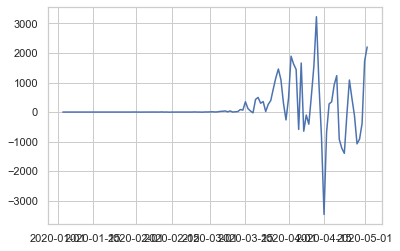

In [160]:
daily_diff = df_res.diff(periods=3)
daily_diff = daily_diff.dropna()
plt.plot(daily_diff)

พบว่าไม่เปลี่ยนแปลงไปจากเดิมมาก จึงขอใช้ period = 1

In [164]:
daily_diff = df_res.diff(periods=1).dropna()

#### AR Model
estimate order of model using Bayesian Information Criterion (BIC)

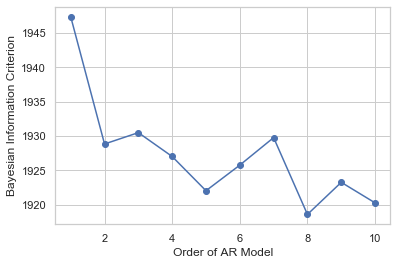

In [202]:
BIC = np.zeros(11)
for p in range(11):
    model = ARMA(daily_diff, order = (p, 0))
    result = model.fit()
    # Save BIC for each AR
    BIC[p] = result.bic

plt.plot(range(1,11), BIC[1:11], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()
warnings.filterwarnings('ignore')

In [203]:
# look like 9 order from BIC in AR Model is good enogh so I will save
p_best = 8

#### MA Model
estimate order of MA Model using Autoregressive Function โดยใช้การประมาณจากการ plot autoregressive ก่อนหน้านี้

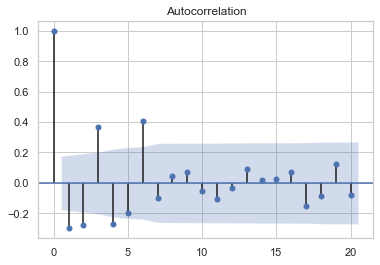

In [204]:
plot_acf(daily_diff, lags = 20)
plt.show()

จากการนับค่าที่เกิน confidence value มาแล้วนับได้ 8 ค่าเห็นจะได้(เกิน max conf) ก็จะลองนำไปทำ MA Model

In [205]:
model = ARMA(daily_diff, order=(0, 6))
result = model.fit()
print(result.summary())

                                ARMA Model Results                               
Dep. Variable:     daily_confirmed_cases   No. Observations:                  123
Model:                        ARMA(0, 6)   Log Likelihood                -930.852
Method:                          css-mle   S.D. of innovations            453.623
Date:                   Wed, 06 May 2020   AIC                           1877.705
Time:                           04:53:15   BIC                           1900.202
Sample:                       01-01-2020   HQIC                          1886.843
                            - 05-02-2020                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          49.3699     36.425      1.355      0.175     -22.022     120.761
ma.L1.daily_confirmed_cases    -0.4017      0.070     -5

In [206]:
print(result.params)

const                          49.369912
ma.L1.daily_confirmed_cases    -0.401713
ma.L2.daily_confirmed_cases    -0.421033
ma.L3.daily_confirmed_cases     0.285246
ma.L4.daily_confirmed_cases    -0.056453
ma.L5.daily_confirmed_cases    -0.125285
ma.L6.daily_confirmed_cases     0.628131
dtype: float64


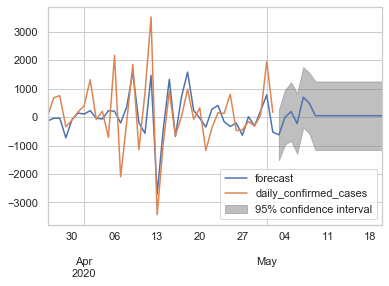

In [207]:
# Try forecast using MA Model
result.plot_predict(start = 85, end = 140)
plt.show()

### Lets do some ARMA model

In [208]:
mod_arma1 = ARMA(daily_diff, order = (8, 6))
res_arma1 = mod_arma1.fit()
print(f'The AIC for an AR order (8, 6) is : {res_arma1.aic}')

The AIC for an AR order (8, 6) is : 1884.9203695267834


#### not too bad but not good

might not be best try change order to get at least aic at possible before we go to ARIMA

In [219]:
mod_arma1 = ARMA(daily_diff, order = (9, 6))
res_arma1 = mod_arma1.fit()
print(f'The AIC for an AR order (8, 6) is : {res_arma1.aic}')

The AIC for an AR order (8, 6) is : 1880.6041603584845


Turn out this is the maximum optimize now, so let do ARIMA by using p and q order from previous ARMA Model

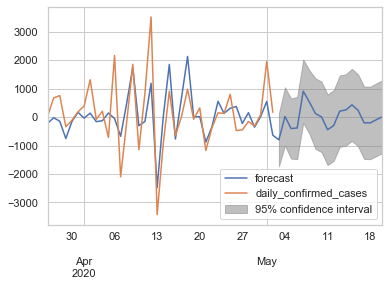

In [223]:
# I use d equal 1 because of 1 different from previous
model_ari1 = ARMA(daily_diff, order = (9, 1, 6))
res_ari1 = model_ari.fit()

res_ari1.plot_predict(start = 85, end = 140)
plt.show()

#### Try change using non different data

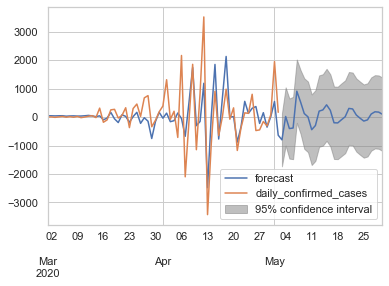

In [230]:
model_ari2 = ARMA(df_res, order = (9, 1, 6))
res_ari2 = model_ari.fit()

res_ari2.plot_predict(start = '2020-03-01', end = '2020-05-30')
plt.show()

<hr>

# 2. Regression model

#### Correlation between all variables

In [67]:
df_res_change = df_res.pct_change()
df_res_change
# At first there might be some 0 data row because there are not
# much infected appear

,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths
date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-04-28,-0.034506,-0.195238,0.028193,0.014051
2020-04-29,-0.072639,1.689349,0.025428,0.037265
2020-04-30,0.020020,-0.125413,0.025294,0.031420


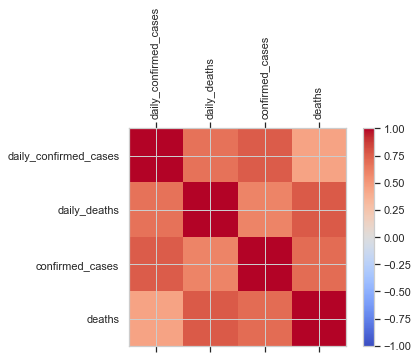

In [74]:
corr = df_res_change.corr()
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(corr, cmap = 'coolwarm', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, len(df_res_change.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation = 90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_res_change.columns)
ax.set_yticklabels(df_res_change.columns)
plt.show()
# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

เหมือนว่าจะมีความสัมพันธ์เป็นไปในเชิงบวกเยอะ งั้นเดี๋ยวลองทำ scatter plot ดู

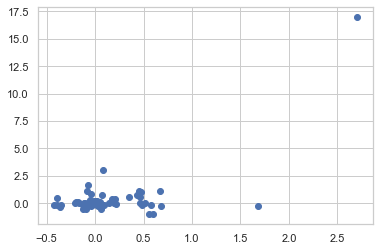

In [75]:
plt.scatter(df_res_change.daily_confirmed_cases, df_res_change.daily_deaths)

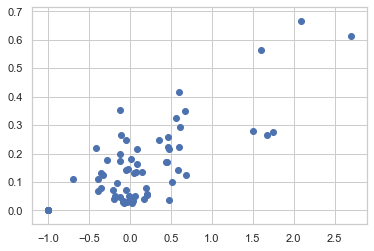

In [76]:
plt.scatter(df_res_change.daily_confirmed_cases, df_res_change.confirmed_cases)

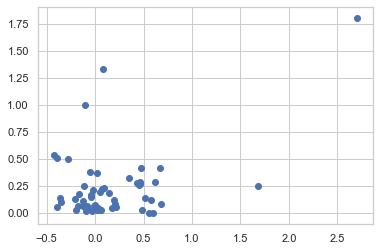

In [77]:
plt.scatter(df_res_change.daily_confirmed_cases, df_res_change.deaths)